### Installing Required Dependencies

In [ ]:
!pip install torch
!pip install torchvision
!pip install torchmetrics
!pip install opencv-contrib-python
!pip install numpy
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user insta

### Downloading and Exploring our Data

In [ ]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "RPS_DATA2"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path /"RPS_DATA2.zip" , "wb") as f:
        request = requests.get("https://github.com/hana-4/acmw_ws/raw/main/RPS_DATA2.zip")
        print("Downloading rock, paper, scissors data...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "RPS_DATA2.zip", "r") as zip_ref:
        print("Unzipping rock, paper, scissors data...")
        zip_ref.extractall(image_path)

data/RPS_DATA2 directory exists.


In [ ]:
import shutil
from pathlib import Path
# Define the path to the _MACOSX folder
macosx_folder = image_path / "__MACOSX"
# Check if the folder exists and delete it
if macosx_folder.is_dir():
    print("Found _MACOSX folder, deleting...")
    shutil.rmtree(macosx_folder)
    print("_MACOSX folder deleted.")
else:
    print("No _MACOSX folder found.")

No _MACOSX folder found.


In [ ]:
# Setup train and testing paths
train_dir = image_path /"RPS_DATA2/train"
test_dir = image_path / "RPS_DATA2/test"

train_dir, test_dir

(PosixPath('data/RPS_DATA2/RPS_DATA2/train'),
 PosixPath('data/RPS_DATA2/RPS_DATA2/test'))

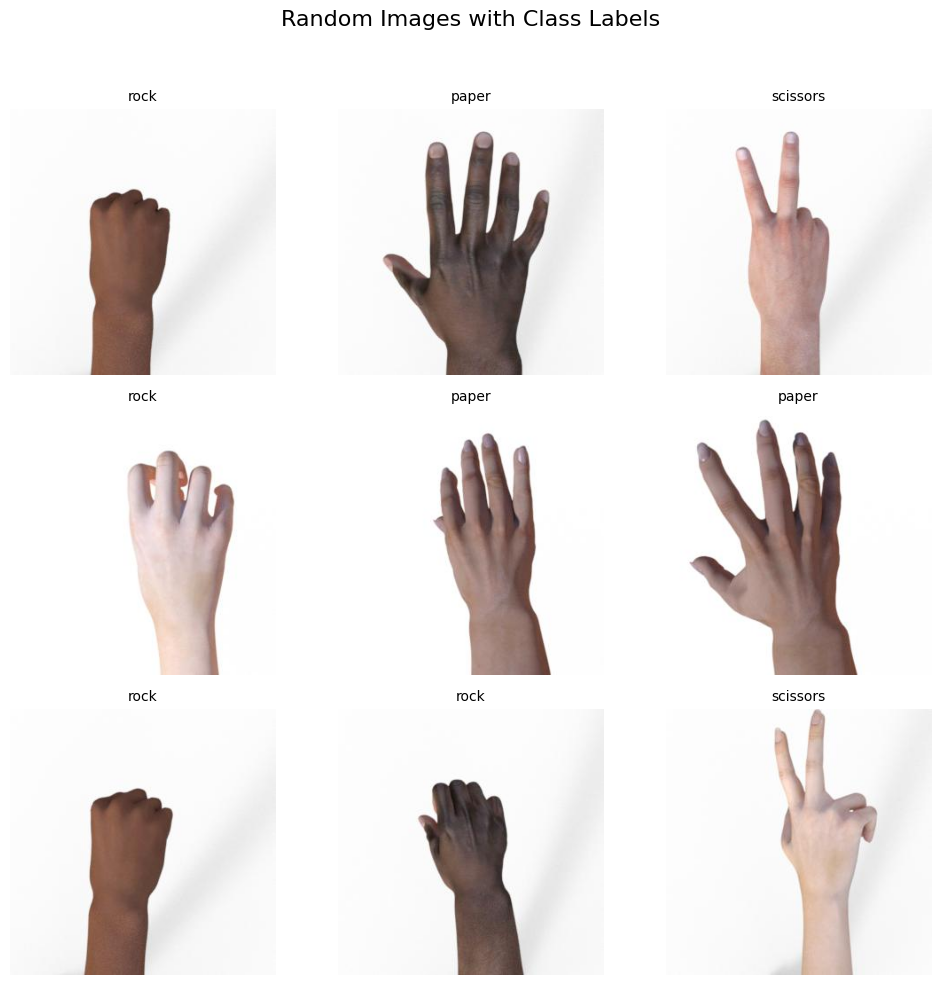

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import cv2 as cv

# Set seed
random.seed(123)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*/*.jpg"))
random_image_paths = random.sample(image_path_list, 9)

# Create a plot
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3x3 grid
fig.suptitle("Random Images with Class Labels", fontsize=16)

# Iterate through the selected images and subplots
for ax, random_image_path in zip(axes.flatten(), random_image_paths):
    # 2. Get image class
    image_class = random_image_path.parent.stem

    # 3. Open image
    img = Image.open(random_image_path)

    # Display image in subplot
    ax.imshow(img)
    ax.axis("off")  # Hide axis
    ax.set_title(image_class, fontsize=10)  # Set the title as the class label

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



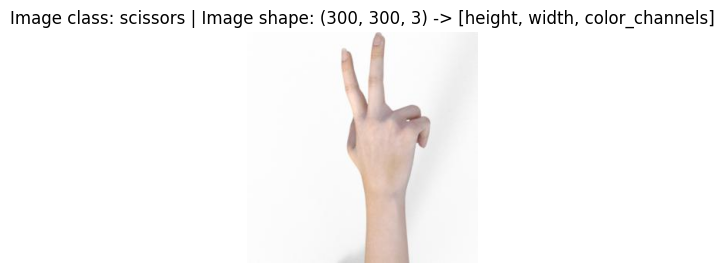

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(3, 3))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

### Building our Pytorch model: From Pixels to Predictions

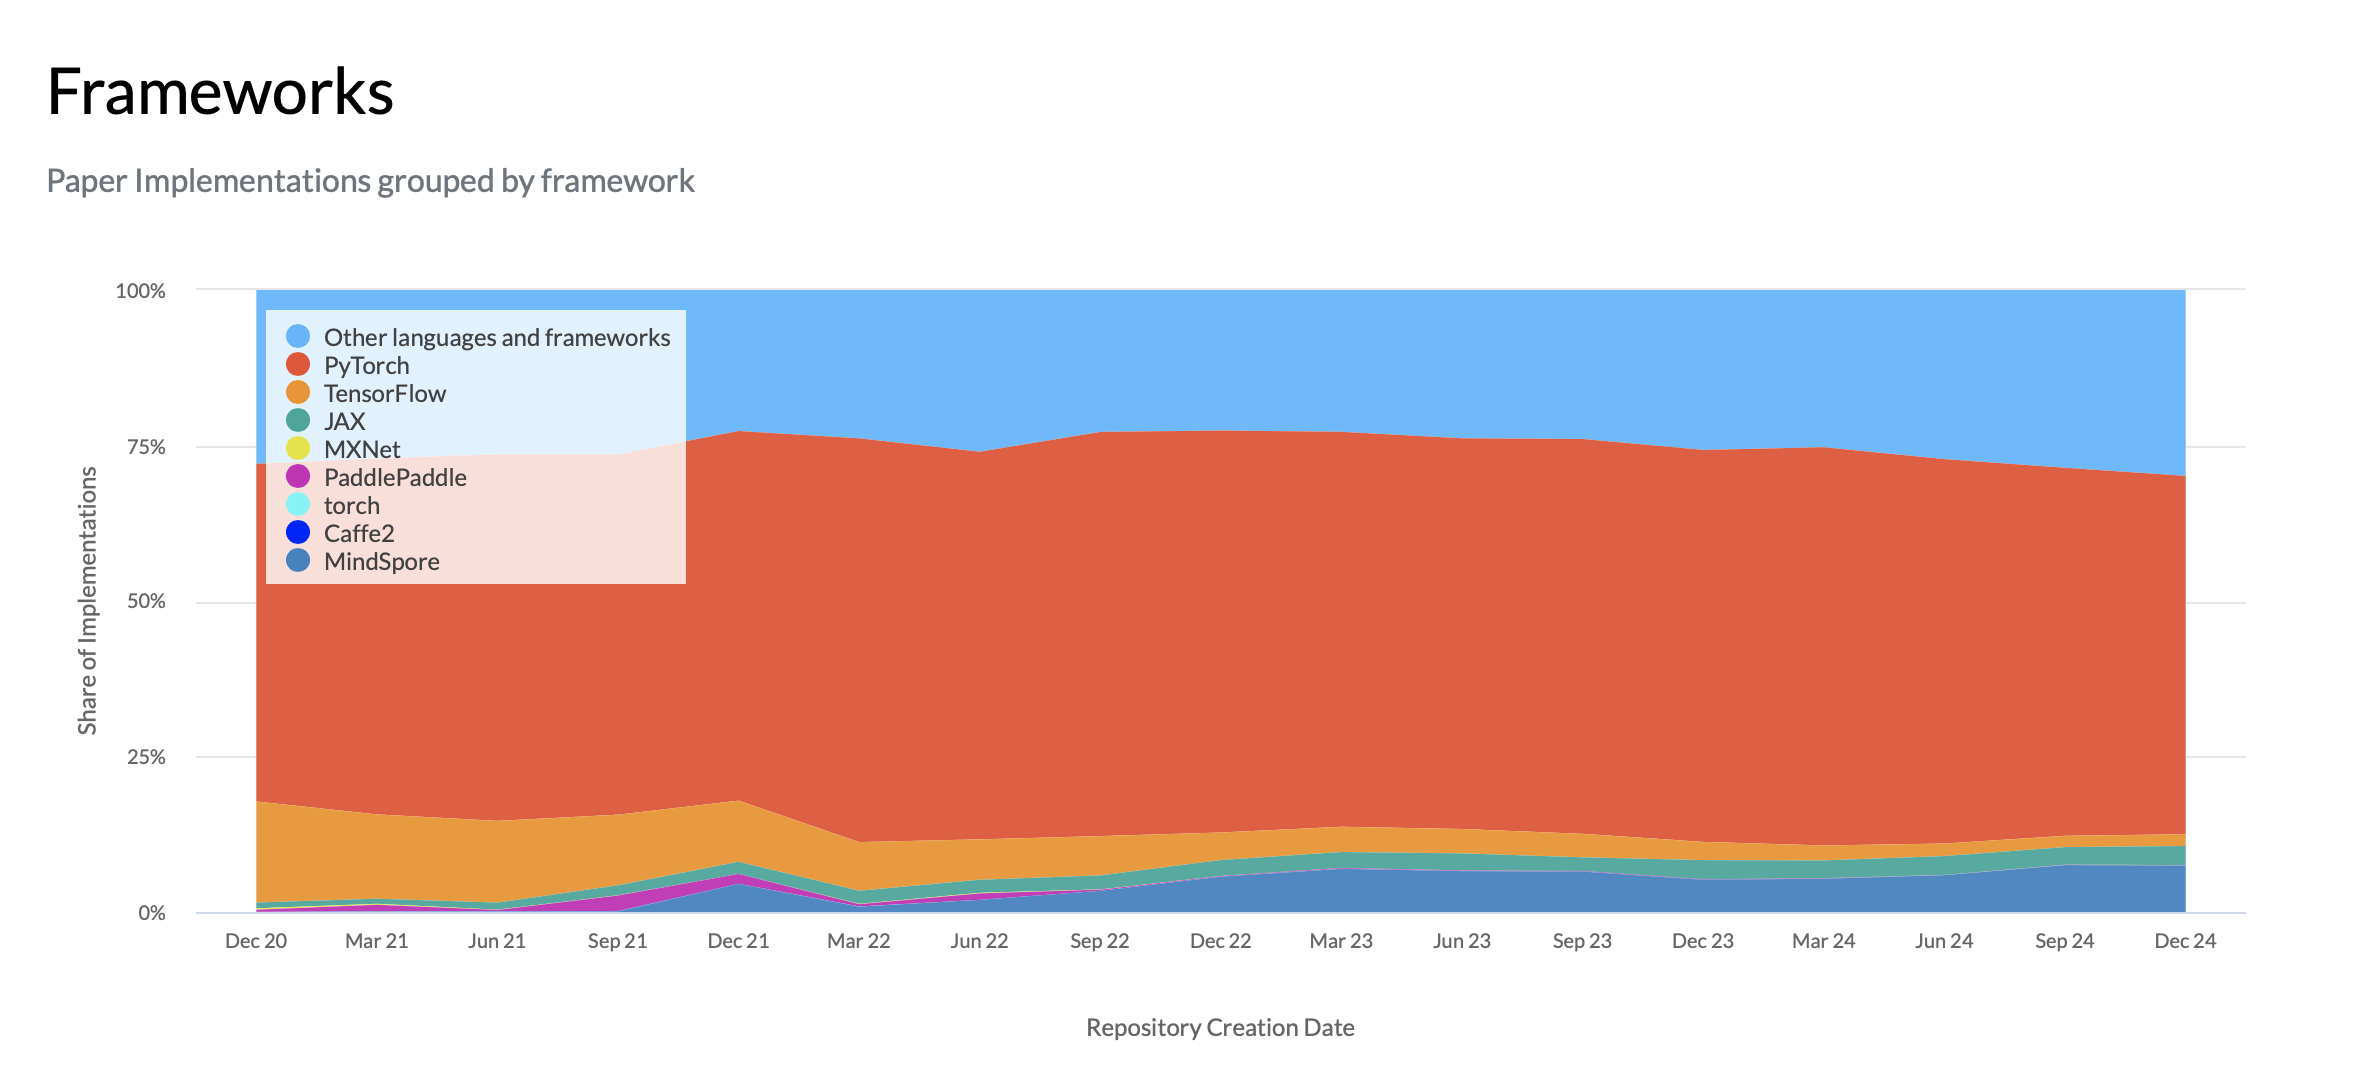







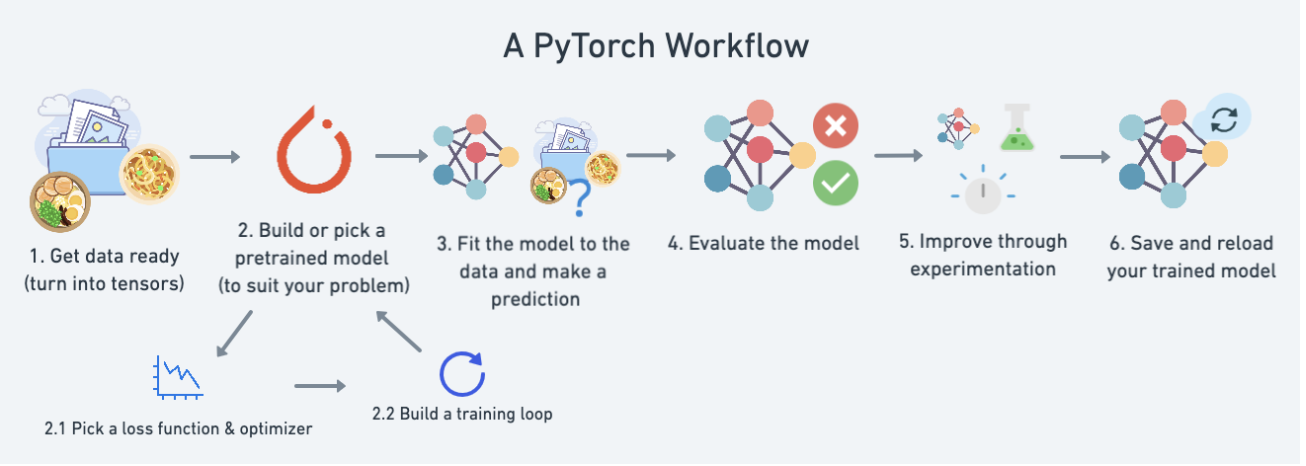

In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms

*  Domain Libraries: TorchVision, TorchText, TorchAudio and TorchRec
*  Each library provides domain-specific datasets, pre-trained models, and utility functions to make model development easier.

In [ ]:
from torch.utils.data import DataLoader

### Defining Transforms to turn images to tensors, resize them and convert them to grayscale

In [ ]:
# Write transform for image
data_transform = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.Grayscale(1),
    transforms.ToTensor()
])

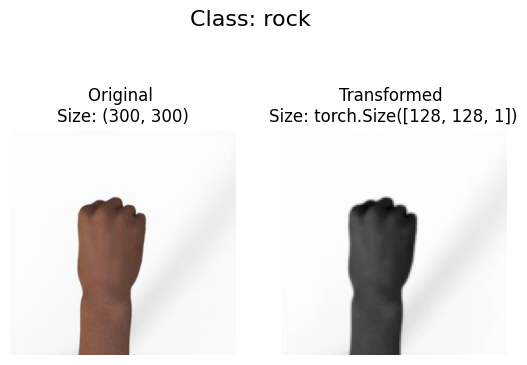

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=123):

    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image, cmap='gray')
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=1)

### Creating a dataset compatible with pytorch

* Time to turn our image data into a Dataset capable of being used with PyTorch.

* PyTorch has many in-built data loading functions for common types of data.

* ImageFolder is helpful if our images are in standard image classification format. i.e.

root/dog/xxx.png

root/dog/xxy.png

root/dog/[...]/xxz.png

root/cat/123.png

root/cat/nsdf3.png

root/cat/[...]/asd932_.png

In [ ]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 1260
    Root location: data/RPS_DATA2/RPS_DATA2/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=1)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 186
    Root location: data/RPS_DATA2/RPS_DATA2/test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=1)
               ToTensor()
           )


In [ ]:
# Get class names as a list
class_names = train_data.classes
class_names

['paper', 'rock', 'scissors']

In [ ]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'paper': 0, 'rock': 1, 'scissors': 2}

In [ ]:
# Check the lengths
len(train_data), len(test_data)

(1260, 186)

In [ ]:
type(train_data[0])

tuple

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9922, 0.9922],
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9922, 0.9922],
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9922, 0.9922]]])
Image shape: torch.Size([1, 128, 128])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


### Turn train and test Datasets into DataLoaders

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=16, # how many samples per batch?

                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=16,

                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16d73e3a0>,
 <torch.utils.data.dataloader.DataLoader at 0x1418945b0>)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([16, 1, 128, 128]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([16])


### Setting up device agnostic code

To allow our model to run on GPU if it's available

In [ ]:
if torch.cuda.is_available():
  device="cuda"
else:
  device="cpu"

### Creating our Convolutional Neural Network

In [ ]:
from torch import nn

In [ ]:
class RPSModule(nn.Module):
    def __init__(self):
        super(RPSModule, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=1), # 20
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.4),

            nn.Conv2d(32, 64, kernel_size=5, padding=1), # 32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.4),

            nn.Conv2d(64, 64, kernel_size=5, padding=1), # 32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.4),

            nn.Flatten(),
            nn.Dropout(0.4),

            nn.Linear(64*14*14, 512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 3)
        )

    def forward(self, x):
        return self.net(x)

### Instantiating our model and setting up its loss function, optimiser and metric

In [ ]:
import torch
from torch import nn

In [ ]:
from torchmetrics import Accuracy
accuracy_fn=Accuracy(task="multiclass", num_classes=3)

In [ ]:
torch.manual_seed(42)
model_1=RPSModule()
optimiser=torch.optim.SGD(params=model_1.parameters(), lr=0.001)
loss_fn=nn.CrossEntropyLoss()

### Defining our train and test step

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU (if available)
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(dim=1),y) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


In [ ]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(
                test_pred.argmax(dim=1), y # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

### Training our Model

In [ ]:
torch.manual_seed(123)

from tqdm.auto import tqdm

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
 train_step(model_1, train_dataloader, loss_fn, optimiser, accuracy_fn, device)
 test_step(test_dataloader, model_1,loss_fn, accuracy_fn, device)


  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.93443 | Train accuracy: 0.55%


 33%|███▎      | 1/3 [00:27<00:54, 27.48s/it]

Test loss: 0.99121 | Test accuracy: 0.49%

Train loss: 0.47888 | Train accuracy: 0.90%


 67%|██████▋   | 2/3 [00:49<00:24, 24.42s/it]

Test loss: 0.56359 | Test accuracy: 0.79%

Train loss: 0.17528 | Train accuracy: 0.98%


100%|██████████| 3/3 [01:13<00:00, 24.58s/it]

Test loss: 0.37635 | Test accuracy: 0.91%



### Saving and loading our Model

In [ ]:
model_1.state_dict()

OrderedDict([('net.0.weight',
              tensor([[[[ 1.5587e-01,  1.6914e-01, -4.3616e-02,  1.8681e-01, -4.1115e-02],
                        [ 4.3274e-02, -9.4286e-02,  1.2062e-01,  1.7938e-01, -1.4395e-01],
                        [ 1.7669e-01,  4.0425e-02,  1.5083e-01,  3.0134e-02,  9.9207e-02],
                        [-2.5553e-02,  1.5706e-01,  3.2572e-02, -9.0324e-02,  5.3802e-02],
                        [-8.9806e-02, -2.0817e-02, -7.8418e-02,  1.3554e-01, -1.5513e-01]]],
              
              
                      [[[-8.8517e-02, -5.2736e-02, -1.1660e-01,  2.2073e-02, -1.9475e-01],
                        [ 1.8418e-01, -1.6627e-01,  1.5811e-01,  3.6612e-02, -6.2139e-02],
                        [ 1.2698e-01,  3.4656e-02,  1.6531e-01,  2.5402e-02, -6.0151e-02],
                        [ 5.6931e-02, -5.0941e-02,  8.7734e-02,  1.8222e-01,  1.1869e-01],
                        [-8.4373e-02,  1.1858e-01,  3.9146e-02,  1.0515e-01, -1.1871e-01]]],
              
           

In [ ]:
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f='rps_weights_FINAL.pth')

In [ ]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model = RPSModule()

import requests
from pathlib import Path
import torch

# Define the URL and local file path
url = "https://github.com/hana-4/acmw_ws/raw/main/rps_model_weights.pth"
save_dir = Path("./weights")
save_dir.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
weights_path = save_dir / "rps_model_weights.pth"

# Download the weights file if it doesn't exist
if not weights_path.exists():
    print(f"Downloading weights from {url}...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(weights_path, "wb") as f:
            f.write(response.content)
        print(f"Weights downloaded and saved to {weights_path}")
    else:
        print(f"Failed to download weights: {response.status_code}")
else:
    print(f"Weights file already exists at {weights_path}")

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model.load_state_dict(torch.load(f='weights/rps_model_weights.pth'))

Weights file already exists at weights/rps_model_weights.pth


<All keys matched successfully>

### Integrating Pytorch and OpenCv: Making the game come alive!

In [ ]:
import torch
import cv2
import numpy as np

# Load your PyTorch model
model = loaded_model # Replace with your actual loaded model
model.eval()  # Set the model to evaluation mode

# Get the expected input size from the model
input_model_size = (128, 128)  # Update this based on your model's input size

# Define class labels
class_labels = {0: 'paper', 1: 'rock', 2: 'scissors'}

# Initialize webcam
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cv2.namedWindow('Rock Paper Scissors')

# Define ROIs for Player 1 and Player 2
roi1_x, roi1_y, roi1_w, roi1_h = 200, 150, 300, 300 # ROI for Player 1
roi2_x, roi2_y, roi2_w, roi2_h = 800, 150, 300, 300  # ROI for Player 2

def determine_winner(player1_choice, player2_choice):
    if player1_choice == player2_choice:
        return "Draw"
    elif (player1_choice == 'rock' and player2_choice == 'scissors') or \
         (player1_choice == 'scissors' and player2_choice == 'paper') or \
         (player1_choice == 'paper' and player2_choice == 'rock'):
        return "Player 1 Wins!"
    else:
        return "Player 2 Wins!"

while True:
    try:
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)

        # Extract ROIs for both players
        roi1 = frame[roi1_y:roi1_y+roi1_h, roi1_x:roi1_x+roi1_w]
        roi2 = frame[roi2_y:roi2_y+roi2_h, roi2_x:roi2_x+roi2_w]

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break

        def predict_choice(roi):
            """Predicts the class label for a given ROI."""
            # Convert ROI to RGB, resize, normalize, and convert to tensor
            roi_resized = cv2.resize(roi, input_model_size, interpolation=cv2.INTER_AREA)
            roi_gray = cv2.cvtColor(roi_resized, cv2.COLOR_BGR2GRAY)
            roi_normalized = roi_gray / 255.0
            roi_tensor = torch.tensor(roi_normalized, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

            # Classify the ROI image using the PyTorch model
            with torch.no_grad():
                prediction_prob =(model(roi_tensor)).squeeze(0).cpu().numpy()
                #prediction_prob=model(roi_tensor)

            predicted_class_index = np.argmax(prediction_prob)
            predicted_class_label = class_labels[predicted_class_index]
            predicted_class_prob = prediction_prob[predicted_class_index]

            if predicted_class_prob < 0.9:
                return 'Undefined'
            else:
                return predicted_class_label


        # Predict choices for both players
        player1_choice = predict_choice(roi1)
        player2_choice = predict_choice(roi2)

        # Determine winner
        if player1_choice != 'Undefined' and player2_choice != 'Undefined':
            result = determine_winner(player1_choice, player2_choice)
        else:
            result = "Waiting for valid input..."

        # Display ROIs and predictions
        cv2.rectangle(frame, (roi1_x, roi1_y), (roi1_x + roi1_w, roi1_y + roi1_h), (255, 0, 0), 2)
        cv2.putText(frame, f'P1: {player1_choice}', (roi1_x, roi1_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

        cv2.rectangle(frame, (roi2_x, roi2_y), (roi2_x + roi2_w, roi2_y + roi2_h), (0, 255, 0), 2)
        cv2.putText(frame, f'P2: {player2_choice}', (roi2_x, roi2_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        # Display the result
        cv2.putText(frame, result, (400, 500), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

        # Show the frame
        cv2.imshow('Rock Paper Scissors', frame)

    except Exception as e:
        print(e)
        break

cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 

### What's Next?

Advanced Applications: Rock Paper Scissors Lizard Spock

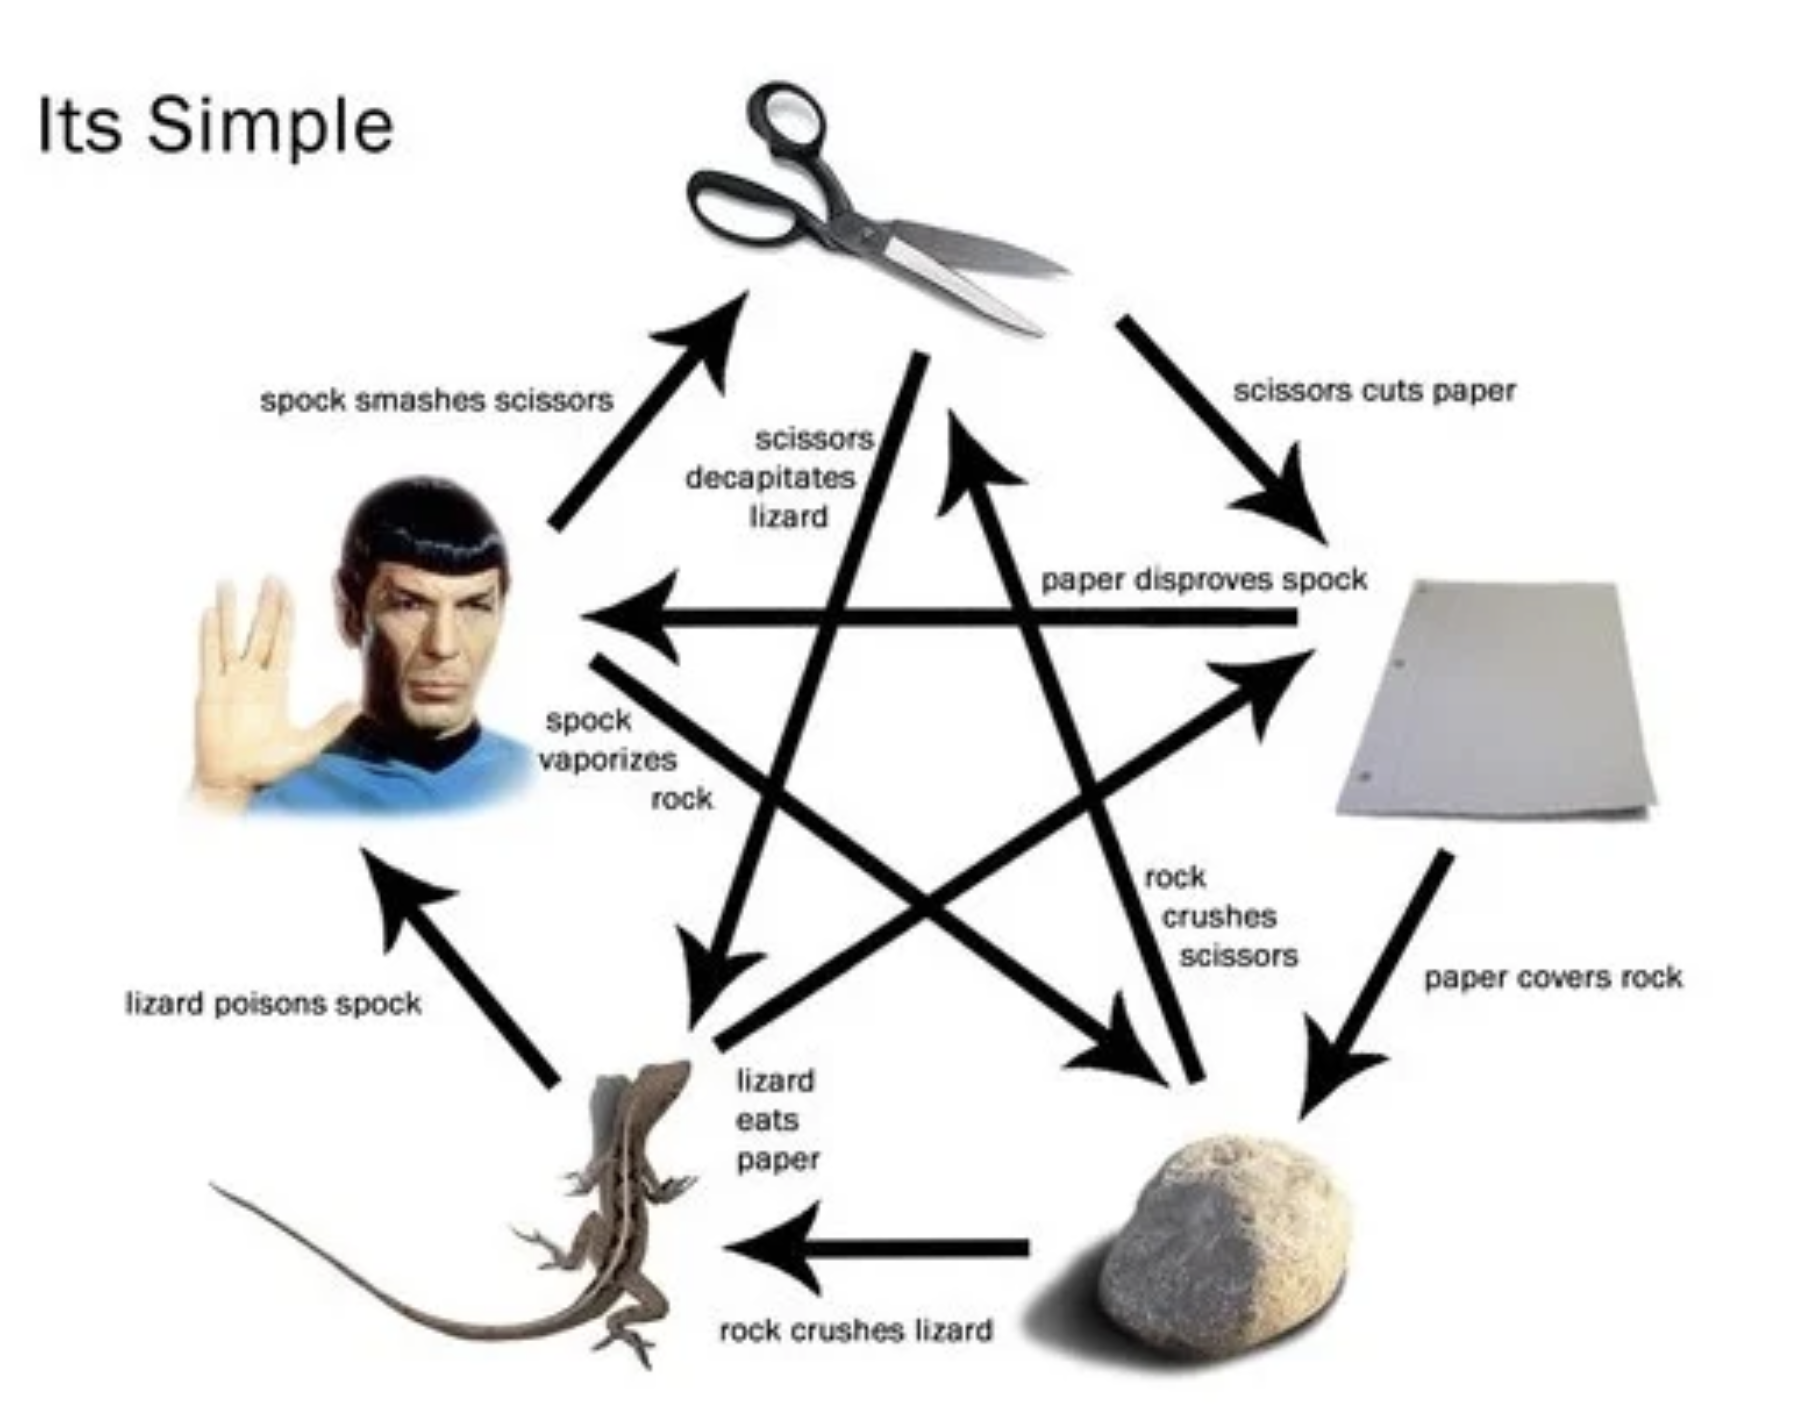

https://www.youtube.com/watch?v=_PUEoDYpUyQ&t=48s